In [2]:
! pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [39]:
!apt-get install -y fonts-noto-color-emoji
import matplotlib.font_manager as fm

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-color-emoji is already the newest version (2.047-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [41]:
emoji_font_path = '/usr/share/fonts/truetype/noto/NotoColorEmoji.ttf'
emoji_font = fm.FontProperties(fname=emoji_font_path, size=10)

In [3]:
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np

In [4]:
(x_train , y_train) , (x_test , y_test) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
x_train.shape

(60000, 28, 28)

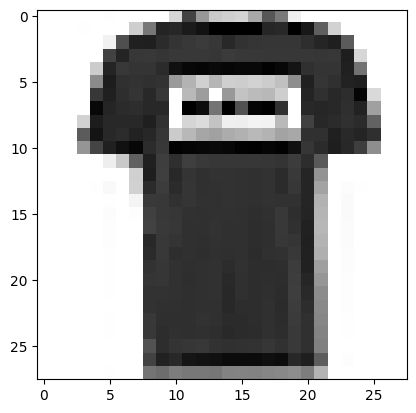

In [62]:
plt.imshow(x_train[1],cmap = 'binary')

In [7]:
def create_model(hp):  # allow hp to be optional
    num_hidden_layers = 1
    num_units = 8
    Dropout_rate = 0.1
    learning_rate = 0.01

    if hp:
        num_hidden_layers = hp.Choice('num_hidden_layers', values=[1, 2, 3])
        num_units = hp.Choice('num_units', values=[8, 16, 32])
        Dropout_rate = hp.Float('Dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    model.add(tf.keras.layers.Lambda(lambda x: x / 255.))  # model normalization

    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_units, activation='relu'))
        model.add(tf.keras.layers.Dropout(Dropout_rate))

    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model


In [8]:
create_model(None).summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
class CustomTuner(kt.tuners.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 128, step=32)
        return super().run_trial(trial, *args, **kwargs)

In [10]:
tuner = CustomTuner(
    create_model,
    objective='val_accuracy',
    max_trials=20,
    directory='logs',
    project_name='Fashion',
    overwrite=True
)

In [11]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
Dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [12]:
tuner.search(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=5, verbose= False
)

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `

In [15]:
tuner.results_summary()

Results summary
Results in logs/Fashion
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
num_hidden_layers: 3
num_units: 32
Dropout_rate: 0.1
learning_rate: 0.0007776554202493605
batch_size: 32
Score: 0.8597999811172485

Trial 18 summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
Dropout_rate: 0.1
learning_rate: 0.009039949176724219
batch_size: 96
Score: 0.8427000045776367

Trial 10 summary
Hyperparameters:
num_hidden_layers: 2
num_units: 16
Dropout_rate: 0.1
learning_rate: 0.0007041351528307284
batch_size: 96
Score: 0.8413000106811523

Trial 13 summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
Dropout_rate: 0.5
learning_rate: 0.0011192978928276462
batch_size: 128
Score: 0.8406000137329102

Trial 00 summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
Dropout_rate: 0.30000000000000004
learning_rate: 0.000154851914505021
batch_size: 32
Score: 0.8371999859809875

Trial 14 summary
Hyperparameters:
num_hidde

In [16]:
tuner.results_summary(1)

Results summary
Results in logs/Fashion
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
num_hidden_layers: 3
num_units: 32
Dropout_rate: 0.1
learning_rate: 0.0007776554202493605
batch_size: 32
Score: 0.8597999811172485


In [17]:
model = tuner.get_best_models(num_models = 1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562 (107.66 KB)

 Trainable params: 27,562 (107.66 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
_ = model.fit(
    x_train,y_train,
    validation_data = (x_test,y_test),
    epochs = 20 , batch_size = 128,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)]
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8583 - loss: 0.3942 - val_accuracy: 0.8604 - val_loss: 0.3799
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8613 - loss: 0.3866 - val_accuracy: 0.8605 - val_loss: 0.3793
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8619 - loss: 0.3816 - val_accuracy: 0.8659 - val_loss: 0.3728
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8686 - loss: 0.3655 - val_accuracy: 0.8649 - val_loss: 0.3748
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8663 - loss: 0.3676 - val_accuracy: 0.8687 - val_loss: 0.3689
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8709 - loss: 0.3592 - val_accuracy: 0.8693 - val_loss: 0.3614
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8727 - loss: 0.3498 - val_accuracy: 0.8697 - val_loss: 0.3664
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8742 - loss: 0.3486 - val_accuracy: 0.

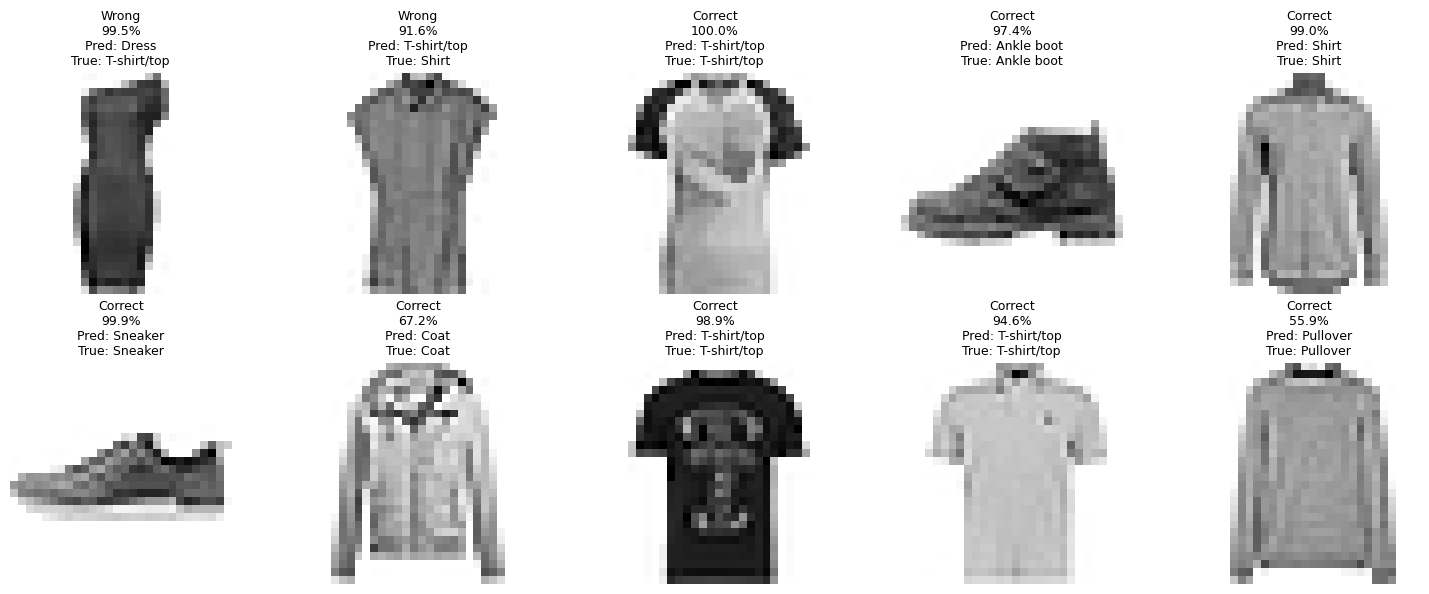

In [47]:
# Class labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Number of images to display
num_images = 10
indices = np.random.choice(len(x_test), num_images, replace=False)

# Store data for sorting
display_data = []

for idx in indices:
    img = x_test[idx]
    label = y_test[idx]
    input_img = img.reshape(1, 28, 28) if len(img.shape) == 2 else img.reshape(1, 28, 28, 1)

    pred = model.predict(input_img, verbose=0)
    pred_label = np.argmax(pred)
    confidence = np.max(pred) * 100

    correct = pred_label == label
    display_data.append((correct, img, label, pred_label, confidence))

# Sort so wrong predictions come first
display_data.sort(key=lambda x: x[0])  # False (wrong) comes before True (correct)

# Plotting
plt.figure(figsize=(15, 6))

for i, (correct, img, true_label, pred_label, conf) in enumerate(display_data):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray_r')
    plt.title(f"{'Correct' if correct else 'Wrong'}\n{conf:.1f}%\nPred: {class_names[pred_label]}\nTrue: {class_names[true_label]}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [55]:
from google.colab import files

uploaded = files.upload()

Saving shoe.jpeg to shoe.jpeg


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_and_prepare_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize((28, 28))  # Resize to 28x28
    img_array = np.array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = img_array.reshape(1, 28, 28)  # Reshape for prediction
    return img_array, img  # Return both the array and the original image for display

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


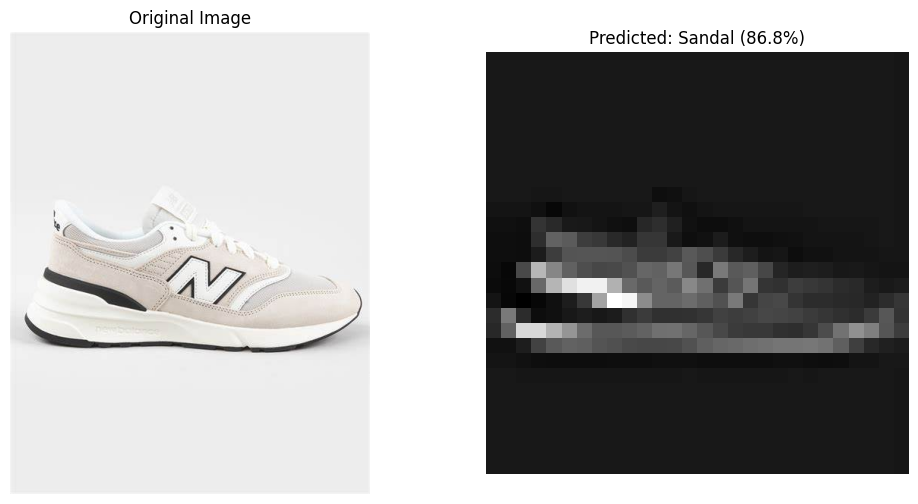

In [61]:
image_path = "/content/shoe.jpeg"  # Path for the image to be processed
image_path2 = "/content/shoe.jpeg"  # Path for the original image to display (same in this case)

input_img, display_img = load_and_prepare_image(image_path)

# Predict
pred = model.predict(input_img)
pred_label = np.argmax(pred)
confidence = np.max(pred) * 100

# Plot the original image and predicted result side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original Image (without going through the load_and_prepare function)
original_img = Image.open(image_path2)  # Open the original image directly
axes[0].imshow(original_img)
axes[0].set_title("Original Image")
axes[0].axis('off')  # Hide axis

# Predicted Image
axes[1].imshow(display_img, cmap='gray_r')
axes[1].set_title(f"Predicted: {class_names[pred_label]} ({confidence:.1f}%)")
axes[1].axis('off')  # Hide axis

plt.show()